In [ ]:
! pip install datasets
!pip install transformers
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import pandas as pd
import io
import os
import re
import string
#import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)


import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,GlobalMaxPooling1D,Embedding,TextVectorization,LayerNormalization,MultiHeadAttention)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector


In [ ]:
# Charger les données dans un DatasetDict
dataset_dict = load_dataset("bigscience/P3",'imdb_Movie_Expressed_Sentiment_2')

# Charger les données de l'ensemble d'entraînement dans un dataframe
train_df = pd.DataFrame(dataset_dict['train'].to_pandas())

# Charger les données de l'ensemble de test dans un dataframe
test_df = pd.DataFrame(dataset_dict['test'].to_pandas())

# Charger les données non supervisées dans un dataframe
#unsupervised_df = pd.DataFrame(dataset_dict['unsupervised'].to_pandas())

In [ ]:
# Afficher les premières lignes de chaque dataframe
train_df.head(3)

,answer_choices,inputs,inputs_pretokenized,targets,targets_pretokenized
0,"[negative, positive]","[37, 826, 1974, 1132, 3980, 15, 7, 125, 6493, ...",The following movie review expresses what sent...,"[1465, 1]",positive
1,"[negative, positive]","[37, 826, 1974, 1132, 3980, 15, 7, 125, 6493, ...",The following movie review expresses what sent...,"[1465, 1]",positive
2,"[negative, positive]","[37, 826, 1974, 1132, 3980, 15, 7, 125, 6493, ...",The following movie review expresses what sent...,"[1465, 1]",positive


In [ ]:
train_df['inputs_pretokenized'][1]

'The following movie review expresses what sentiment? Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they\'ll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it\'s like to be homeless? That is Goddard Bolt\'s lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see

In [ ]:
train_df1= pd.DataFrame(train_df[['targets_pretokenized', 'inputs_pretokenized']])   #train/test
test_df1= pd.DataFrame(train_df[['targets_pretokenized', 'inputs_pretokenized']])

train_df1.head(3)

,targets_pretokenized,inputs_pretokenized
0,positive,The following movie review expresses what sent...
1,positive,The following movie review expresses what sent...
2,positive,The following movie review expresses what sent...


## **_Transformer les données textuelles en tokens et de réduire la dimensionnalité du corpus en réduisant le vocabulaire_** 

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from collections import defaultdict
nltk.download('punkt')

def freq_stats_corpora2(df, text_column_name, target_column_name, lookup_table=[]):
    corpora = defaultdict(list)
    stop_words = set(nltk.corpus.stopwords.words('english'))

    tokenize_and_filter_stopwords = lambda text: [w.lower() for w in nltk.word_tokenize(text) if not w.lower() in stop_words]

    for idx, row in df.iterrows():
        tokens = tokenize_and_filter_stopwords(row[text_column_name])
        corpora[row[target_column_name]] += tokens

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
    return (freq, stats, corpora)

freq2, stats2, corpora2 = freq_stats_corpora2(train_df1, 'inputs_pretokenized', 'targets_pretokenized')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Define a function to determine if a word is positive or not
def is_positive(word):
    positive_words = [' positive']
    if word in positive_words:
        return 1
    else:
        return 0

# Apply the function to a pandas DataFrame column
def apply_positive_indicator(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: is_positive(x))
    return df


In [ ]:
train_df1 = apply_positive_indicator(train_df1, 'targets_pretokenized')
test_df1 = apply_positive_indicator(test_df1, 'targets_pretokenized')

train_df1.head(3)

,targets_pretokenized,inputs_pretokenized
0,1,The following movie review expresses what sent...
1,1,The following movie review expresses what sent...
2,1,The following movie review expresses what sent...


In [ ]:
import re
import string
import nltk
from nltk.stem import SnowballStemmer
import plotly.graph_objects as go
from collections import defaultdict

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
# remove link and composit words with more then 4 words, link, put in lowercase


def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)


def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)


def remove_punct(text):
    """
        Remove the punctuation
    """
#     return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return text.translate(str.maketrans('', '', string.punctuation))
# remove punctuations from the text


def convert_to_lowercase(text):
    """
    Converts the input text to lowercase.
    """
    return text.lower()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_df1['inputs_pretokenized'] = train_df1['inputs_pretokenized'].apply(lambda text: re.sub(r'\bhttps?://\S+|www\.\S+', '', text))
train_df1['inputs_pretokenized'] = train_df1['inputs_pretokenized'].apply(lambda text: ' '.join([w for w in text.split() if len(w.split()) <= 4]))
train_df1['inputs_pretokenized'] = train_df1['inputs_pretokenized'].apply(lambda text: ' '.join([w for w in text.split() if len(w.split()) <= 4 and not any(c in w for c in ['...', ',', ';', ':', '/', '"', "'", "'s", "'t"])]))
train_df1["inputs_pretokenized"] = train_df1["inputs_pretokenized"].apply(lambda x: x.lower())
train_df1["inputs_pretokenized"] = train_df1["inputs_pretokenized"].apply(lambda x: remove_URL(x))
# remove html from the text
train_df1["inputs_pretokenized"] = train_df1["inputs_pretokenized"].apply(lambda x: remove_html(x))
train_df1["inputs_pretokenized"] = train_df1["inputs_pretokenized"].apply(lambda x: remove_punct(x))

test_df1['inputs_pretokenized'] = test_df1['inputs_pretokenized'].apply(lambda text: re.sub(r'\bhttps?://\S+|www\.\S+', '', text))
test_df1['inputs_pretokenized'] = test_df1['inputs_pretokenized'].apply(lambda text: ' '.join([w for w in text.split() if len(w.split()) <= 4]))
test_df1['inputs_pretokenized'] = test_df1['inputs_pretokenized'].apply(lambda text: ' '.join([w for w in text.split() if len(w.split()) <= 4 and not any(c in w for c in ['...', ',', ';', ':', '/', '"', "'", "'s", "'t"])]))
test_df1["inputs_pretokenized"] = test_df1["inputs_pretokenized"].apply(lambda x: x.lower())
test_df1["inputs_pretokenized"] = test_df1["inputs_pretokenized"].apply(lambda x: remove_URL(x))
# remove html from the text
test_df1["inputs_pretokenized"] = test_df1["inputs_pretokenized"].apply(lambda x: remove_html(x))
test_df1["inputs_pretokenized"] = test_df1["inputs_pretokenized"].apply(lambda x: remove_punct(x))

## -------------- ajouter 

train_df1["inputs_pretokenized"] = train_df1["inputs_pretokenized"].apply(lambda x: convert_to_lowercase(x))
test_df1['inputs_pretokenized'] = test_df1['inputs_pretokenized'].apply(lambda x : convert_to_lowercase(x))



In [ ]:

def freq_stats_corpora2(data, text_column_name):
    stop_words = nltk.corpus.stopwords.words('english')
    stemmer = SnowballStemmer('english')
    
    # Create a list of all words in the text column
    all_words = data[text_column_name].apply(lambda text: ' '.join([w for w in text.split() if len(w.split()) <= 4]))
    all_words = all_words.apply(lambda text: nltk.word_tokenize(text))
    all_words = all_words.apply(lambda tokens: [w.lower() for w in tokens if w.lower() not in stop_words and w.lower() not in string.punctuation])
    all_words = all_words.apply(lambda tokens: [stemmer.stem(w) for w in tokens])
    all_words = all_words.tolist()
    all_words = [word for sublist in all_words for word in sublist] # Flatten list
    
    # Count the frequency of each word in the list
    freq = defaultdict(int)
    for word in all_words:
        freq[word] += 1
    
    # Sort the words by frequency in descending order
    sorted_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    
    # Take only the top 100 most frequent words
    top_words = sorted_freq[:100]
    words = [w[0] for w in top_words]
    word_counts = [w[1] for w in top_words]
    
    # Create an interactive bar chart using plotly
    fig = go.Figure([go.Bar(x=words, y=word_counts)])
    fig.update_layout(
        title="Word frequencies",
        xaxis_title="Words",
        yaxis_title="Counts",
        xaxis_tickangle=-45,
        bargap=0.1,
    )
    fig.show()
    
    stats = {'total': len(all_words), 'unique': len(set(all_words))}
    
    return 

In [ ]:
freq_stats_corpora2(train_df1, 'inputs_pretokenized')
freq_stats_corpora2(test_df1, 'inputs_pretokenized')

In [ ]:
from nltk.tokenize import word_tokenize

train_df1['tokenized'] = train_df1['inputs_pretokenized'].apply(word_tokenize)
test_df1['tokenized'] = test_df1['inputs_pretokenized'].apply(word_tokenize)

train_df1.head(3)

,targets_pretokenized,inputs_pretokenized,tokenized
0,1,the following movie review expresses what sent...,"[the, following, movie, review, expresses, wha..."
1,1,the following movie review expresses what sent...,"[the, following, movie, review, expresses, wha..."
2,1,the following movie review expresses what sent...,"[the, following, movie, review, expresses, wha..."


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# drop stop words 

def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
    return df



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
remove_stopwords(train_df1)
remove_stopwords(test_df1)

train_df2= pd.DataFrame(train_df1[['targets_pretokenized', 'tokenized']])
test_df2= pd.DataFrame(test_df1[['targets_pretokenized', 'tokenized']])

train_df2.head(3)

,targets_pretokenized,tokenized
0,1,"[following, movie, review, expresses, sentimen..."
1,1,"[following, movie, review, expresses, sentimen..."
2,1,"[following, movie, review, expresses, sentimen..."


In [ ]:
%time 
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))


def lemmatize_word(text):
    """
    Lemmatize the tokenized words with their POS tags
    """

    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(text)
    lemma = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]
    return lemma

def get_wordnet_pos(treebank_tag):
    """
    Map TreeBank part-of-speech tags to WordNet part-of-speech tags
    """

    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN  # default to noun if no match found


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_df2['tokenized'] = train_df2['tokenized'].apply(lemmatize_word)
train_df2['lemmatize_word_w_pos'] = train_df2['tokenized'].apply(lambda x: [word for word in x if word not in stop])
train_df2['lemmatize_word_w_pos_str'] = train_df2['lemmatize_word_w_pos'].apply(lambda x: ' '.join(x))

test_df2['tokenized'] = test_df2['tokenized'].apply(lemmatize_word)
test_df2['lemmatize_word_w_pos'] = test_df2['tokenized'].apply(lambda x: [word for word in x if word not in stop])
test_df2['lemmatize_word_w_pos_str'] = test_df2['lemmatize_word_w_pos'].apply(lambda x: ' '.join(x))

train_df2_select= pd.DataFrame(train_df2[['targets_pretokenized', 'lemmatize_word_w_pos_str', 'lemmatize_word_w_pos']])
test_df2_select= pd.DataFrame(test_df2[['targets_pretokenized', 'lemmatize_word_w_pos_str', 'lemmatize_word_w_pos']])

In [ ]:
train_df2_select.head(3)

,targets_pretokenized,lemmatize_word_w_pos_str,lemmatize_word_w_pos
0,1,follow movie review express sentiment bromwell...,"[follow, movie, review, express, sentiment, br..."
1,1,follow movie review express sentiment homeless...,"[follow, movie, review, express, sentiment, ho..."
2,1,follow movie review express sentiment brillian...,"[follow, movie, review, express, sentiment, br..."


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
#train_df2_select = pd.DataFrame(train_df2[['targets_pretokenized', 'lemmatize_word_w_pos_str', 'lemmatize_word_w_pos']])

# Define the preprocessing function
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Apply the preprocessing function to the lemmatize_word_w_pos_str column
train_df2_select['preprocessed'] = train_df2_select['lemmatize_word_w_pos_str'].apply(preprocess)
train_df2_select.head(3)

# Apply the preprocessing function to the lemmatize_word_w_pos_str column
test_df2_select['preprocessed'] = test_df2_select['lemmatize_word_w_pos_str'].apply(preprocess)
test_df2_select.head(3)

,targets_pretokenized,lemmatize_word_w_pos_str,lemmatize_word_w_pos,preprocessed
0,1,follow movie review express sentiment bromwell...,"[follow, movie, review, express, sentiment, br...","[follow, movie, review, express, sentiment, br..."
1,1,follow movie review express sentiment homeless...,"[follow, movie, review, express, sentiment, ho...","[follow, movie, review, express, sentiment, ho..."
2,1,follow movie review express sentiment brillian...,"[follow, movie, review, express, sentiment, br...","[follow, movie, review, express, sentiment, br..."


Un modèle Word2Vec est un algorithme d'apprentissage automatique utilisé pour transformer des mots en vecteurs de nombres réels, qui sont ensuite utilisés pour représenter les mots dans un espace vectoriel. Cette technique de modélisation de mots est utilisée pour capturer les relations sémantiques et syntactiques entre les mots.

Les vecteurs générés par un modèle Word2Vec peuvent être utilisés pour diverses tâches liées au traitement du langage naturel, telles que la classification de texte, l'analyse des sentiments, la traduction automatique, la reconnaissance automatique de la parole, etc. Ils peuvent également être utilisés pour des tâches plus spécifiques, telles que la suggestion de mots similaires à un mot donné ou la détection des relations sémantiques entre les mots.

En somme, un modèle Word2Vec est un outil important pour les applications de traitement du langage naturel, car il permet de représenter les mots sous forme de vecteurs numériques qui peuvent être facilement manipulés et utilisés pour diverses tâches liées au traitement de texte.

In [ ]:
from gensim.models import Word2Vec

# Build the Word2Vec model
model = Word2Vec(train_df2_select['preprocessed'], vector_size=50, window=5, min_count=1, workers=12)

# Get the embedding vectors and word labels
word_labels = model.wv.index_to_key
embedding_vectors = [model.wv.get_vector(word) for word in word_labels]

#print(word_labels)
#print(embedding_vectors)



Après avoir entraîné le modèle Word2Vec, nous avons utiliser les vecteurs d'embedding pour faire une analyse de sentiment en utilisant différentes techniques. Un exemple de méthode pour effectuer une analyse de sentiment en utilisant les vecteurs d'embedding c'est de creer une liste de tous les mots présents dans l' ensemble de données de test.
Utuliser la méthode model.wv.get_vector(word) pour récupérer le vecteur d'embedding pour chaque mot de la liste.
Calculer la moyenne des vecteurs d'embedding pour tous les mots présents dans une phrase pour obtenir un vecteur d'embedding pour la phrase.
Utiliser le vecteur d'embedding de la phrase pour effectuer une classification de sentiment en utilisant une méthode telle que la régression logistique ou le SVM.

Le vecteur utilisé dans ce code est un vecteur de représentation d'un mot généré par un modèle Word2Vec. Ce vecteur représente le mot sous forme de nombres réels dans un espace vectoriel, où des mots similaires ont des vecteurs similaires. Le code utilise ces vecteurs pour calculer le vecteur moyen pour chaque phrase dans le jeu de données d'entraînement et de test, et entraîner un modèle de régression logistique sur ces vecteurs moyens pour prédire le sentiment de chaque phrase.

En d'autres termes, le modèle utilise les vecteurs de représentation de mots pour convertir chaque phrase en un vecteur moyen dans l'espace vectoriel, où les positions relatives des vecteurs reflètent la similitude sémantique des mots. Le modèle de régression logistique est ensuite entraîné sur ces vecteurs moyens pour prédire la polarité de chaque phrase. Cette approche est souvent utilisée dans les tâches de classification de texte où les modèles doivent prédire la classe ou la catégorie d'une phrase ou d'un document donné.

###  **Modelisation**

### ***  Benchmark model : classification de sentiments binaires basé sur le naïve Bayes multinomial ***

```
Pour construire un modèle de classification de sentiments binaires basé sur le naïve Bayes multinomial, nous devons suivre ces étapes :

Préparer les données : Nous pouvons utiliser la colonne prétraitée pour notre analyse.

Diviser les données en ensembles d'apprentissage et de test.

Vectoriser les données : Convertir le texte prétraité en fonctionnalités numériques qui peuvent être alimentées dans le modèle. Nous pouvons utiliser CountVectorizer ou TfidfVectorizer pour y parvenir.

Entraîner le modèle : Nous pouvons utiliser la classe MultinomialNB de la bibliothèque scikit-learn pour entraîner notre modèle.

Tester le modèle : Nous pouvons utiliser l'ensemble de test pour évaluer les performances de notre modèle.```



In [ ]:
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB


X_train = train_df2_select['preprocessed']
X_test = test_df2_select['preprocessed']
y_train = train_df2_select['targets_pretokenized']
y_test = test_df2_select['targets_pretokenized']

# Define the maximum sequence length
max_length = 500

# Vectorize the data using Word2Vec
model = Word2Vec(X_train, vector_size=50, window=5, min_count=1, workers=12)
X_train = np.array([np.mean([model.wv[token] for token in doc if token in model.wv], axis=0) for doc in X_train])
X_test = np.array([np.mean([model.wv[token] for token in doc if token in model.wv], axis=0) for doc in X_test])

# Pad sequences with zeros so that they all have the same length
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', dtype='float32')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', dtype='float32')

# Scale the data to ensure all values are non-negative
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
model = MultinomialNB()
history1 = model.fit(X_train, y_train)

# Test the model
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.66744


Accuracy: 0.6628


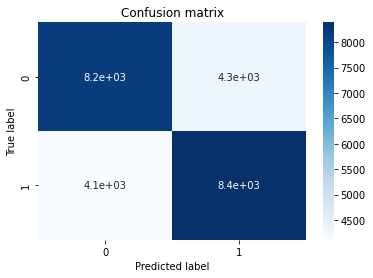

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Test the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# ***1.  LSTM Model ***

In [ ]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import numpy as np

# Build the Word2Vec model
model = Word2Vec(train_df2_select['preprocessed'], vector_size=50, window=5, min_count=1, workers=12)

# Get the embedding vectors and word labels
word_labels = model.wv.index_to_key
embedding_vectors = [model.wv.get_vector(word) for word in word_labels]

# Create embedding matrix
embedding_matrix = np.array(list(map(lambda word: model.wv.get_vector(word) if model.wv.get_vector(word) is not None else np.zeros(50), word_labels)))

#embedding_matrix = np.zeros((len(word_labels), 50))
#for i, word in enumerate(word_labels):
    #embedding_vector = model.wv.get_vector(word)
    #if embedding_vector is not None:
        #embedding_matrix[i] = embedding_vector

# Convert text data to sequences of indices
train_sequences = [[word_labels.index(word) for word in doc] for doc in train_df2_select['preprocessed']]
test_sequences = [[word_labels.index(word) for word in doc] for doc in test_df2_select['preprocessed']]

# Pad sequences to make them the same length
max_len = max([len(seq) for seq in train_sequences + test_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_len)
test_sequences = pad_sequences(test_sequences, maxlen=max_len)


In [ ]:

# Build the LSTM model
model = Sequential([
    Embedding(len(word_labels), 50, weights=[embedding_matrix], input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
#model.fit(train_sequences, train_df2_select['targets_pretokenized'], validation_data=(test_sequences, test_df2_select['targets_pretokenized']), epochs=10)


In [ ]:
# Train the model and get the history object (run more then 25 min)
history = model.fit(train_sequences, train_df2_select['targets_pretokenized'], 
                    validation_data=(test_sequences, test_df2_select['targets_pretokenized']), 
                    epochs=10)


In [ ]:
model.summary()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_sequences, test_df2_select['targets_pretokenized'])
print('Test accuracy:', test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 222, 50)           3977050   
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,006,555
Trainable params: 4,006,555
Non-trainable params: 0
_________________________________________________________________
782/782 [==============================] - 42s 54ms/step - loss: 2.6264e-04 - accuracy: 1.0000
Test accuracy: 1.0


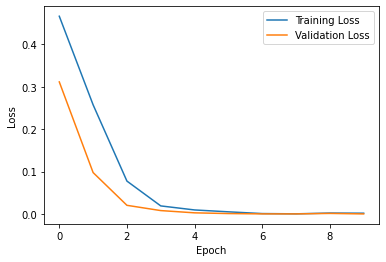

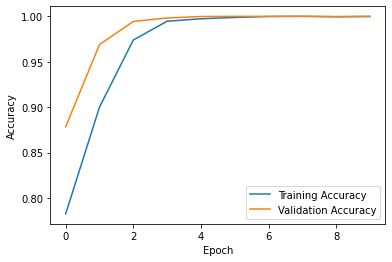

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


###  **2. Modèle de classification de sentiment binaire basé sur des réseaux de neurones à propagation avant**

Ce modèle est un réseau de neurones artificiels pour la classification binaire. Il prend en entrée une séquence de mots, représentée sous forme d'entiers, et utilise une couche d'embedding pour transformer chaque entier en un vecteur de taille 50. La couche d'embedding utilise une matrice de poids pré-entraînée (embedding_matrix) pour convertir les entiers en vecteurs.

Ensuite, il utilise deux couches LSTM (Long Short-Term Memory) avec des mécanismes de dropout pour extraire les caractéristiques des séquences. La première couche LSTM renvoie les séquences complètes, tandis que la deuxième couche LSTM renvoie uniquement la dernière sortie.

Le modèle ajoute ensuite trois couches Denses (complètement connectées) avec des fonctions d'activation ReLU pour effectuer des calculs de classification. Il utilise également des couches Dropout pour éviter le surapprentissage. Finalement, il utilise une couche Dense avec une fonction d'activation sigmoïde pour donner une sortie de classification binaire (0 ou 1).

Le modèle est compilé avec l'optimiseur Adam et la perte binaire croisée, et utilise la précision comme métrique d'évaluation. Il est ensuite entraîné sur les données d'entraînement (X_train et y_train) avec une taille de lot de 64 et 10 époques. Les données de validation (X_test et y_test) sont utilisées pour évaluer les performances du modèle après chaque époque.


In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
import numpy as np
from keras.layers import Dense, Embedding, Flatten
from keras.models import Sequential

# Load pre-trained word2vec model
word2vec_model = Word2Vec(train_df2_select['preprocessed'], vector_size=50, window=5, min_count=1, workers=12)

# Define the maximum length of a text sequence
max_length = 50

# Tokenize the text data
tokenizer = Tokenizer()
to_str = lambda x: str(x)
tokenizer.fit_on_texts(list(map(to_str, X_train)))
X_train = tokenizer.texts_to_sequences(list(map(to_str, X_train)))
X_test = tokenizer.texts_to_sequences(list(map(to_str, X_test)))
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')


# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]



# Define the model architecture
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model3 = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
391/391 [==============================] - 155s 376ms/step - loss: 0.6944 - accuracy: 0.4972 - val_loss: 0.6930 - val_accuracy: 0.5090
Epoch 2/10
391/391 [==============================] - 146s 374ms/step - loss: 0.6930 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 3/10
391/391 [==============================] - 146s 374ms/step - loss: 0.6929 - accuracy: 0.5130 - val_loss: 0.6913 - val_accuracy: 0.5521
Epoch 4/10
391/391 [==============================] - 146s 375ms/step - loss: 0.6913 - accuracy: 0.5257 - val_loss: 0.6891 - val_accuracy: 0.5556
Epoch 5/10
391/391 [==============================] - 146s 375ms/step - loss: 0.6905 - accuracy: 0.5322 - val_loss: 0.6899 - val_accuracy: 0.5635
Epoch 6/10
391/391 [==============================] - 147s 377ms/step - loss: 0.6864 - accuracy: 0.5542 - val_loss: 0.6776 - val_accuracy: 0.6003
Epoch 7/10
391/391 [==============================] - 146s 374ms/step - loss: 0.6771 - accuracy: 0.5874 - val_loss: 0.6615 -

Test accuracy: 64.156002


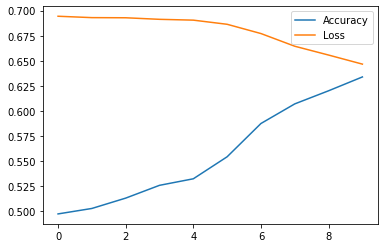

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: %f' % (accuracy*100))

# Plot the accuracy and loss graphs
import matplotlib.pyplot as plt
plt.plot(model3.history['accuracy'], label='Accuracy')
plt.plot(model3.history['loss'], label='Loss')
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            2840250   
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           91648     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)               

### *** 3. Roberta model ***

In [ ]:

from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

MODEL_NAME = 'roberta-base'
MAX_LEN = 256

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)


Number of replicas: 1


In [ ]:
categories = train_df2_select['targets_pretokenized'].values.reshape(-1)

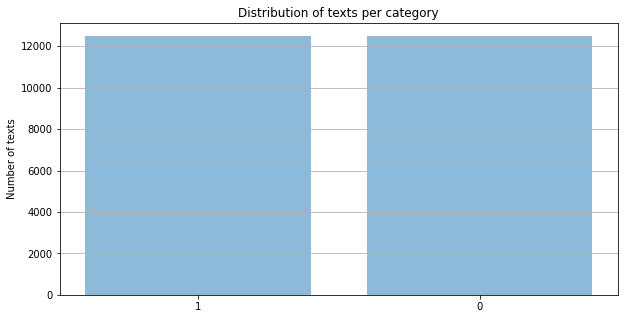

Counter({1: 12500, 0: 12500})


In [ ]:
counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
import statistics
import seaborn as sns
import math

def calculate_stats(df, split_char=' '):
    categories = train_df2_select['targets_pretokenized'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['preprocessed']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['targets_pretokenized']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = train_df2_select['targets_pretokenized'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [ ]:
df_stats = calculate_stats(train_df2_select)
df_stats['per_category']

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Convert to string
        text = str(text)
        
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }


In [ ]:
import numpy as np

X_train = np.array(train_df2_select['preprocessed'])
X_test = np.array(test_df2_select['preprocessed'])
y_train = train_df2_select['targets_pretokenized']
y_test = test_df2_select['targets_pretokenized']

X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
# Transform categories into numbers
X_data = train_df2_select[['lemmatize_word_w_pos_str']].to_numpy().reshape(-1)
y_data = train_df2_select[['targets_pretokenized']].to_numpy().reshape(-1)


In [ ]:
input_word_ids = X_train['input_word_ids']
input_mask = X_train['input_mask']
input_type_ids = X_train['input_type_ids']

In [ ]:
import numpy as np

def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        #  transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.GlobalMaxPooling1D()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model


In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)


Texts in dataset: 25000


In [ ]:
categories = train_df2_select['targets_pretokenized'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

Number of categories: 2


In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

Le modèle TFRoBERTaModel prend en entrée des identifiants de mots (input_word_ids), un masque d'attention (input_mask), et des identifiants de type (input_type_ids) pour les séquences de texte. Ensuite, il produit une sortie qui comprend un état caché final (last_hidden_state) avec une forme (None, 256, 768), un vecteur de sortie de pooler (pooler_output) avec une forme (None, 768), et des attributs facultatifs tels que les clés passées (past_key_values), les états cachés intermédiaires (hidden_states), les scores d'attention (attentions) et les scores d'attention croisée (cross_attentions).

RoBERTa est un modèle de langage de pointe pré-entraîné qui peut être utilisé pour diverses tâches de traitement du langage naturel, telles que la classification de texte, la génération de texte, la traduction de langue et bien d'autres.

In [ ]:
maxlen = 0

for sequence in X_train:
    if len(sequence) > maxlen:
        maxlen = len(sequence)

print("Maximum sequence length:", maxlen)


Maximum sequence length: 14


In [ ]:
EPOCHS = 3
BATCH_SIZE = 5

with strategy.scope():
    print('Training...')
    history = model.fit({'input_word_ids': X_train['input_word_ids'], 'input_mask': X_train['input_mask'], 'input_type_ids': X_train['input_type_ids']}, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=({'input_word_ids': X_test['input_word_ids'], 'input_mask': X_test['input_mask'], 'input_type_ids': X_test['input_type_ids']}, y_test))


Training...


  818/25000 [..............................] - ETA: 21:44:21 - loss: 0.8376 - accuracy: 0.5098

KeyboardInterrupt: ignored

Le modèle RoBERTa (Robustly Optimized BERT approach) est considéré comme une amélioration significative du modèle BERT (Bidirectional Encoder Representations from Transformers). Bien qu'ils partagent la même architecture de base, RoBERTa surpasse BERT sur plusieurs tâches de traitement du langage naturel, grâce à plusieurs changements clés apportés lors de son entraînement :

Plus de données d'entraînement : RoBERTa a été entraîné sur 10 fois plus de données que BERT. Cela inclut non seulement les données de l'ensemble original de BERT, mais aussi des données supplémentaires provenant de sources telles que Wikipedia, CommonCrawl et des corpus de texte en plusieurs langues.

Prétraitement sans masque : RoBERTa a été pré-entraîné sans masque, ce qui signifie que le modèle prend en compte l'ensemble des tokens dans la séquence plutôt que de masquer certains d'entre eux. Cette approche permet d'exploiter plus efficacement les informations contextuelles de la séquence.

Entraînement plus long : RoBERTa a été entraîné pendant beaucoup plus longtemps que BERT, avec des hyperparamètres d'entraînement optimaux qui ont été trouvés grâce à une recherche plus exhaustive.

Ces modifications ont permis à RoBERTa de surpasser BERT sur plusieurs tâches de traitement du langage naturel, notamment la classification de texte, la compréhension de texte et la génération de texte. En particulier, RoBERTa a dépassé les résultats de l'état de l'art sur plusieurs benchmarks de classification de texte, tels que GLUE et SuperGLUE.

En conclusion, RoBERTa est considéré comme une amélioration significative de BERT grâce à son prétraitement sans masque, son entraînement plus long et son utilisation de plus de données. Cela a permis à RoBERTa de surpasser BERT sur plusieurs tâches de traitement du langage naturel et de devenir l'un des modèles de langage les plus performants à ce jour.

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [ ]:
#Confusion Matrix

def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:
plot_confusion_matrix(X_test, y_test, model)